data/﻿SZ000333_lrb.csv
data/SZ000651_lrb.csv
data/﻿SZ000333_fzb.csv
data/SZ000651_fzb.csv
data/﻿SZ000333_llb.csv
data/SZ000651_llb.csv


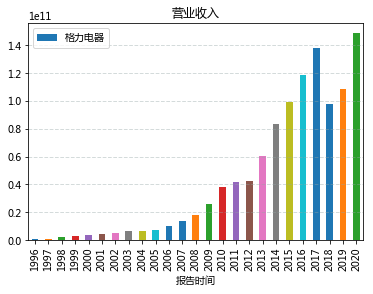

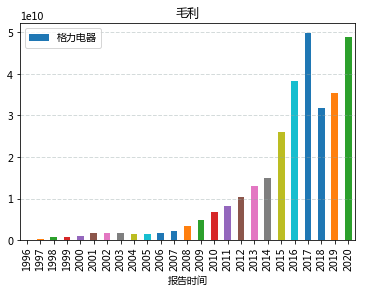

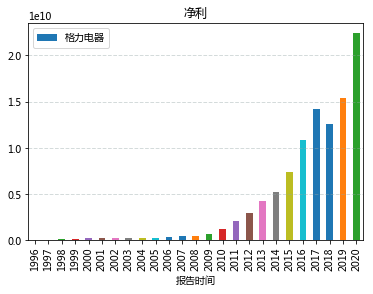

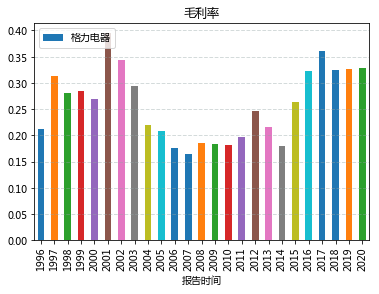

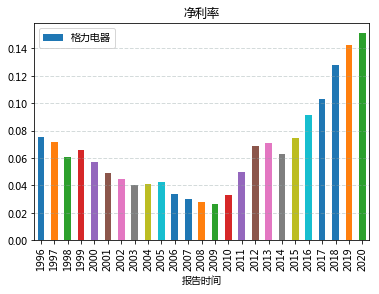

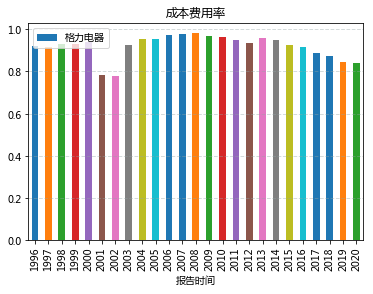

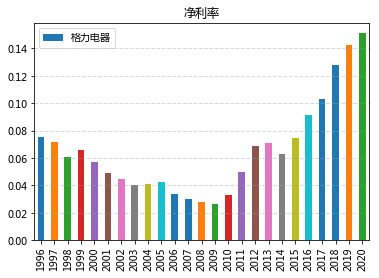

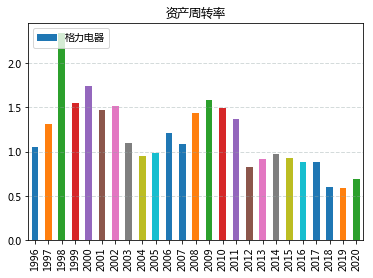

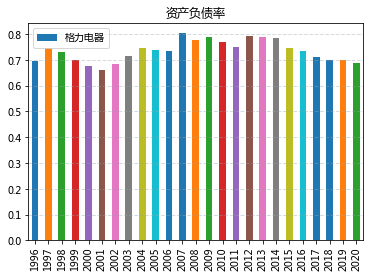

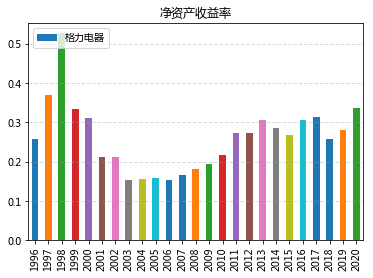

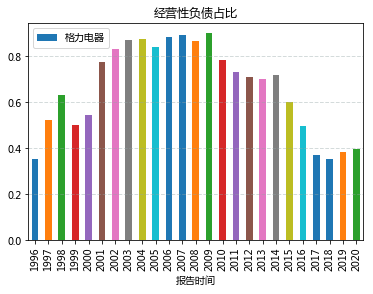

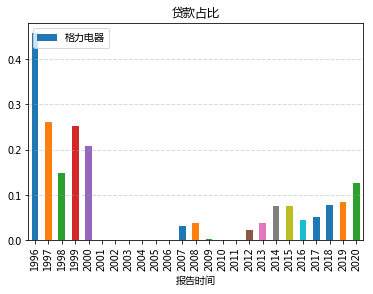

In [3]:
# 来源自: https://blog.csdn.net/m0_46298067/article/details/107988359



import pandas as pd
import requests
from multiprocessing.dummy import Pool as ThreadPool

lrb_base_url = 'http://api.xueqiu.com/stock/f10/incstatement.csv?page=1&size=10000&symbol='
llb_base_url = 'http://api.xueqiu.com/stock/f10/cfstatement.csv?page=1&size=10000&symbol='
fzb_base_url = 'http://api.xueqiu.com/stock/f10/balsheet.csv?page=1&size=10000&symbol='

headers = {'User-Agent': 'Mozilla/5.0'}

def download_lrb(url):
    r = requests.get(url, headers=headers)
    filename = 'data/' + url.split('=')[-1] + '_lrb.csv'
    print(filename)
    with open(filename, 'wb') as f:
        f.write(r.content)

def download_fzb(url):
    r = requests.get(url, headers=headers)
    filename = 'data/' +url.split('=')[-1] + '_fzb.csv'
    print(filename)
    with open(filename, 'wb') as f:
        f.write(r.content)

def download_llb(url):
    r = requests.get(url, headers=headers)
    filename = 'data/' +url.split('=')[-1] + '_llb.csv'
    print(filename)
    with open(filename, 'wb') as f:
        f.write(r.content)

with open('股票代码.txt', 'r', encoding='utf-8') as f:
    symbol = [s.strip() for s in f.readlines()]

lrb_urls = [lrb_base_url + i for i in symbol]
fzb_urls = [fzb_base_url + i for i in symbol]
llb_urls = [llb_base_url + i for i in symbol]

pool = ThreadPool(10)
pool.map(download_lrb, lrb_urls)
pool.close()
pool.join()
pool = ThreadPool(10)
pool.map(download_fzb, fzb_urls)
pool.close()
pool.join()
pool = ThreadPool(10)
pool.map(download_llb, llb_urls)
pool.close()
pool.join()

# 导入所需要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#输入要分析的公司的股票代码

# 股票代码
stock_0 = 'SZ000651' #格力电器
# 输入年份（输入年报数据截止年份的下一年）
year = 2021

#定义函数：读取csv文件，转化为DataFrame格式

def get_lrb(stock_id):
    # 读取利润表数据
    lrb = pd.read_csv(
        r'data/%s_lrb.csv' % (stock_id),
        encoding='utf-8',
        header=0,
        index_col=None)

    list_lrb = []    #获取所有截止日期的列表
    for i in lrb['报表期截止日']:
        list_lrb.append(str(i))
    list_lrb_0 = []  #将20171231的格式转换为2017-12-31
    for i in list_lrb:
        i_ = i[:4] + '-' + i[4:6] + '-' + i[6:8]
        list_lrb_0.append(i_)

    lrb['报告时间'] = [pd.to_datetime(t) for t in list_lrb_0]  #转为日期数据类型

    lrb.index = lrb['报告时间']    #重新设置利润表索引

    data_lrb = lrb[::-1]  #由于csv中为时间倒序，将表倒序排列使之呈时间正序
    return data_lrb

def get_fzb(stock_id):
    # 读取资产负债表表数据
    fzb = pd.read_csv(
        r'data/%s_fzb.csv' % (stock_id),
        encoding='utf-8',
        header=0,
        index_col=None)

    list_fzb = []    
    for i in fzb['报表日期']:
        list_fzb.append(str(i))
    list_fzb_0 = []  
    for i in list_fzb:
        i_ = i[:4] + '-' + i[4:6] + '-' + i[6:8]
        list_fzb_0.append(i_)

    fzb['报告时间'] = [pd.to_datetime(t) for t in list_fzb_0]

    fzb.index = fzb['报告时间'] 

    data_fzb = fzb[::-1]
    return data_fzb

#定义函数：筛选出年报数据，根据月份筛选，12月的即为年报数据

def get_data_month(data, month):
    data_month = data[data.index.month == month]
    return data_month
#定义函数：实现数据可视化

def data_plot(data, y, legend='格力电器', kind='bar'):
    l_0 = len(data)
    s_0 = list(range(l_0))
    x_0 = np.array(s_0)
    y_0 = tuple([str(i) for i in range(year - l_0, year)])
    
    data[y].plot(kind=kind)
    plt.title(y)
    plt.legend([legend], loc='upper left')
    plt.xticks(x_0, y_0)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y',alpha=0.4)
    plt.savefig(r'pic/%s.png' % (y,))
    return

# 经营分析：公司业绩
def get_performance(data):
    result_p = pd.DataFrame()
    #业绩结果
    result_p['营业收入'] = data['营业收入']
    result_p['毛利'] = data['营业收入'] - data['营业成本']
    result_p['净利'] = data['归属于母公司所有者的净利润'] 
    
    #业绩质量 
    result_p['毛利率'] = (data['营业收入'] - data['营业成本']) / data['营业收入']
    result_p['净利率'] = data['归属于母公司所有者的净利润'] / data['营业收入']
    result_p['成本费用率'] =  (data['营业成本']+data['营业税金及附加']+data['销售费用']+data['管理费用']+data['财务费用'] )/ data['营业收入']
    
    result_p.index = data['报告时间']
    return result_p

#实现数据读取、筛选、计算、可视化

# 读取数据
data_lrb = get_lrb(stock_0) #数据全部来自利润表
# 筛选年报数据
data_lrb_year = get_data_month(data_lrb, 12)
# 计算所需指标
result_p = get_performance(data_lrb_year)
#可视化
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #显示中文
for i in ['营业收入','毛利','净利','毛利率','净利率','成本费用率']:
    data_plot(result_p, i)
    plt.show()

tmp_xx = '''（2）公司经营水平分析
经营水平的核心指标有净利率、资产周转率、资产负债率、净资产收益率。数据来自利润表和资产负债表。
定义函数：计算经营水平分析需要的指标
'''
# 经营分析：经营水平
def get_management(data):
    result_m = pd.DataFrame()
  
    result_m['净利率'] = data['归属于母公司所有者的净利润'] / data['营业收入']
    result_m['资产周转率'] = data['营业收入'] / data['资产总计']
    result_m['资产负债率'] = data['负债合计'] / data['资产总计']
    result_m['净资产收益率'] = data['归属于母公司所有者的净利润'] / (data['资产总计']-data['负债合计'])
    
    result_m.index = data.index
    return result_m


#实现数据读取、筛选、计算、可视化：

#读取数据，数据来自利润表和资产负债表
data_lrb = get_lrb(stock_0)
data_fzb = get_fzb(stock_0)
#筛选年报数据
data_lrb_year = get_data_month(data_lrb, 12)
data_fzb_year = get_data_month(data_fzb, 12)
#将利润表和资产负债表合为一表，方便计算
data=pd.merge(left=data_lrb_year,right=data_fzb_year,left_on='报表期截止日', right_on='报表日期',) 
#计算所需指标
result_m = get_management(data)
#可视化
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
for i in ['净利率','资产周转率','资产负债率','净资产收益率']:
    data_plot(result_m, i)
    plt.show()

tmp_xx = '''三、风险分析
这里深入分析一下格力的资产负债率，即使不进行同类对比，也可以看出格力的资产负债率非常高，几乎始终在70%~80%之间，资产负债率普遍较高的房地产企业平均水平也就70%左右（此处只是举例，资产负债率不能跨行业对比）。理论上高资产负债率的企业风险更大（偿债压力大），那么格力这么高的资产负债率是否真的意味着高风险？
理论上讲，高资产负债率带来的风险即偿债风险，公司面临较大偿债压力，因此需要进一步探究企业的流动负债结构以判别高风险是否真实存在。
定义函数：分析流动负债结构
'''
def get_structure(data):
    result_s = pd.DataFrame()
    data=data.fillna(0) #填充空值为0
    
    result_s['经营性负债占比'] = (data['应付账款']+data['应付票据']+data['预收款项']) / data['流动负债合计']
    result_s['贷款占比'] = (data['短期借款']+data['一年内到期的非流动负债']) / data['流动负债合计']
   
    result_s.index = data['报告时间']
    return result_s

#实现数据读取、筛选、计算、可视化：

data_fzb = get_fzb(stock_0)
data_fzb_year = get_data_month(data_fzb, 12)
result_s = get_structure(data_fzb_year)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
for i in ['经营性负债占比','贷款占比']:
    data_plot(result_s, i)
    plt.show()


In [4]:
#!/usr/bin/env python

# -*- coding: utf-8 -*-

import pandas as pd

from selenium import webdriver

from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.common.by import By

from selenium.webdriver.support.wait import WebDriverWait

from selenium.webdriver.common.action_chains import ActionChains

from datetime import datetime

import time

def get_data(url):

browser = webdriver.Chrome()

WebDriverWait(browser, 10)

browser.get(url)

WebDriverWait(browser, 5, 0.5).until(EC.presence_of_element_located((By.ID, 'sidemenu')))

above = browser.find_element_by_css_selector(

"#sidemenu > div > div.level-list > ul > li.sub-items.menu-hsindex-wrapper")

ActionChains(browser).move_to_element(above).perform()

lis = browser.find_elements_by_xpath("//*[@id='sidemenu']/div/div[2]/ul/li[7]/div/ul//li")

for li in lis:

    print(li)

if "指数成份" in li.text:

# li.click()

# get_page_num(browser, "指数成份")

    print()

elif "上证系列指数" in li.text:

# li.click()

# get_page_num(browser, "上证系列指数")

    print()

elif "深证系列指数" in li.text:

    li.click()

    get_page_num(browser, "深证系列指数")

def get_page_num(browser, name):

    wait = WebDriverWait(browser, 10)

try:

    wait.until(EC.presence_of_element_located((By.ID, 'main-table_next')))

    page = int(browser.find_element_by_xpath("//*[@id='main-table_paginate_page']/a[last()]").text)

except Exception as e:

    print(e)

    page = 0

    i = 1

    df = pd.DataFrame()

while i <= page:

input_num = wait.until(EC.presence_of_element_located((By.XPATH, '//*[@class="paginate_input"]')))

input_num.click()

input_num.clear()

input_num.send_keys(i)

submit = wait.until(EC.element_to_be_clickable(

(By.XPATH, '//*[@class="paginte_go"]')))

submit.click()

data = pd.read_html(browser.page_source, converters={'代码': str})[0]

data.drop(['序号'], axis=1, inplace=True)

data['代码'].astype(str)

print("正在爬取第" + str(i) + "页")

df = df.append(data)

i = i + 1

time.sleep(2)

df['指数'] = name

df.to_csv(datetime.now().strftime('%Y%m%d') + name + ".csv", index=False)

print(name, "抓取数据成功")

browser.implicitly_wait(10)

if __name__ == '__main__':

get_data('http://quote.eastmoney.com/center/boardlist.html#boards-BK01501')

# search_next = browser.find_element_by_css_selector("#main-table_next")

# while search_next.is_enabled():

# print("点击下一页")

# search_next.click()

# print(pd.read_html(browser.page_source)[0])

IndentationError: expected an indented block (<ipython-input-4-624d4a1039b5>, line 23)

In [ ]:
import re,urllib
import xlwt
from bs4 import BeautifulSoup
from time import sleep
count = 1
for count in range(600500,603800):
    url = 'http://quotes.money.163.com/service/lrb_'+str(count)+'.html'
    while True:
        try:
            content = urllib.request.urlopen(url,timeout=2).read()
            print(content)
            with open('data/'+str(count)+'lrb.csv','wb') as f:
                f.write(content)
            print(count)
            sleep(1)
            break
        except Exception as e:
            if str(e) =='HTTP Error 404: Not Found':
                break
            else:
                print(e)
                continue

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1738840,5416194,3742692,2457631,1200419,5284646,3962205,2664908,1256470,5995657,4488153,3041763,1411745,6246607,3497607,2488528,1317833,4065675,2888405,1962441,845352,4374569,2824069,1922067,777837,3860520,2798007,1910692,905003,46

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),61245,370045,213488,137717,46474,300014,169954,94535,39059,263225,176111,111826,43195,263602,172553,109877,42291,318341,166688,114062,46228,318059,247032,163523,64763,362527,248102,182524,69252,376624,261476,178282,67411,400303,235

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1411251,5697244,3802401,2361522,663576,4726556,2935863,1900192,718073,3882799,2569265,1630997,738294,3545710,2401340,1389302,212537,1147743,781626,538808,258590,915012,677310,450425,206451,840943,616035,398832,182568,681223,537920,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),45020,107957,97622,58210,47761,234568,20041,13809,6294,38689,26933,21444,14409,211002,114003,71069,68273,95599,55494,43091,14788,43023,14342,5158,1823,41196,31894,26597,12856,72138,54965,39467,15766,109536,90695,80287,64697,113704,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),24758,96191,70237,42138,20765,94837,69172,44089,22178,94537,69790,43831,21886,91973,67209,42226,21940,90075,63378,39298,20600,83698,60367,36487,18465,76313,53840,31867,15786,65273,48316,30421,14292,62054,45566,28806,13801,55414,413

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1409,11858,1257,1256,408,2203,666,444,150,4256,2277,2249,1453,6532,4174,3385,916,6503,3267,1985,721,5387,4759,4312,1361,11181,7303,4702,2481,11511,4806,2032,1064,6075,3853,1423,994,13835,902,480,201,6139,1115,333,235,2308,1392,334,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),404164,1660148,1185621,735716,318370,1538900,1109394,825303,393618,1728585,1278198,823823,386286,1394475,1012691,627171,275620,892378,603517,379254,169686,814829,631429,426415,203601,1150930,869745,580065,282275,1321466,964147,6361

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),200659,765412,543949,363455,174832,762255,556693,367457,186267,684920,518713,342012,175163,633407,478617,305644,140742,517954,357891,236273,112790,496039,376342,251752,120856,635165,489158,339508,159409,846101,659270,452067,214109,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),153313,489578,338714,228500,124756,489429,339557,225344,134744,495588,349719,230017,121858,423784,287496,189451,102737,363604,265402,171779,87720,348397,257585,170901,95127,355896,261174,160526,83064,310750,217335,138574,72090,2918

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),223723,1021160,673121,357458,226498,777696,610588,329744,118993,675831,290658,202037,118692,628922,467075,332502,165947,607538,485422,340501,147993,432348,309625,241040,153537,527465,452474,355508,208041,455706,308741,183464,88883,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1034685,4037861,2911109,1753105,820980,4464448,3270986,2102208,1004889,3873983,2877712,1877109,912992,3628475,2706766,1760408,356800,1338642,991836,652465,326920,1207819,907129,593973,293934,1153834,854456,558364,270489,1008147,744

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),204251,590342,342978,177043,69015,436796,244735,146947,76849,351325,239538,138189,59464,358965,230045,152753,66724,306827,209658,153061,69118,292106,200968,123804,73983,291353,130236,88157,52675,185153,110477,78636,42929,137330,896

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),33201,138604,96464,61590,29221,129033,88864,55461,24592,101924,72515,46336,22499,68910,47848,29568,13230,60486,46974,31083,15705,64243,49692,32832,17163,66869,51338,33632,16695,62330,46428,28658,7852,32536,24111,15339,7604,32421,24

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),134163,631479,367554,187089,77094,1152644,644442,340731,206603,1165636,595196,286654,131054,1115708,769866,550699,134165,993652,531914,78975,40666,132101,95049,64963,35550,111562,73027,51890,27927,103670,64751,47045,25122,76290,481

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),93041,353917,260038,163536,82131,675091,563543,393896,180100,1165095,917584,608268,352192,835048,522928,181343,69274,239529,170872,107157,47333,233041,179689,119139,63396,344901,264207,178751,90419,337345,264797,189453,94906,395071

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),140607,809159,493152,272373,97395,517681,303948,205631,106085,492902,284870,178761,67876,572979,390572,261558,113949,698711,447966,296860,132915,637696,302025,179193,79115,420137,242317,150840,64052,326891,175863,112236,51729,15459

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),108776,541201,397158,251682,116980,1126317,1034727,813267,490164,1935623,2542843,1695934,913518,2647697,1951453,1326236,715466,2164232,1645606,1120350,588572,1806683,1345542,906514,500230,1594919,1157730,776192,419653,1335873,94773

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),2806474,9799324,6957488,4563437,2529849,8885434,6350866,4117268,2248053,7719938,5496927,3525146,1839526,6106276,4448737,2549390,1391341,4015508,2753274,1873762,1025087,3344686,2373432,1618565,876037,3221721,2217326,1461564,758174,3

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),8678,33204,22288,14144,5313,25876,19423,12469,5417,30763,22181,14904,6467,31305,23108,14593,6772,21396,15762,10254,4978,19164,15342,10399,4962,30120,23282,14472,6891,32632,24702,16226,5705,28089,21005,13938,6046,28310,20841,12779,6

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),149685,648521,487061,330553,157056,538809,401160,265297,119908,509460,384284,253873,123904,500200,351002,235044,112954,409285,292240,198301,96801,350036,242192,163570,73055,258499,180620,115003,52267,229641,169626,122618,59528,2014

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1100149,4406573,3035772,2089521,889262,3877100,2918540,1857725,1081896,3392356,2366074,1570564,662100,2710140,1936533,1230110,539341,2110795,1458074,920358,431491,1652295,1057696,624002,282839,864134,609426,394274,158165,677133,483

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),56673,223611,155090,95390,42190,220800,157876,105798,51908,279850,210741,142977,67197,339114,238847,170031,91573,336121,237689,157712,72114,320075,219202,153537,69702,306753,214926,145860,61563,272026,186968,133228,50422,261253,197

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),122620,618769,429589,236093,76334,641500,421495,289605,141643,713688,540211,353636,157674,743296,531445,309061,116821,584896,395023,242444,111678,416185,281364,157485,72425,334864,232041,138510,57810,282151,192650,116227,48541,2413

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),52200,311128,199822,138897,55304,341603,208754,143818,76023,352095,307789,187330,81257,380512,280216,181704,75086,368941,240906,159336,69805,338416,237045,149823,64042,278338,196366,119474,57675,196002,148582,94863,45428,167620,119

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),19655,114454,88927,66530,19253,115275,81683,53775,28070,137156,98174,62365,30720,142941,99625,54064,23402,118819,78883,48664,23119,149020,106283,70112,32574,164383,109450,71170,34417,163375,116384,77669,30481,152248,114284,73778,33

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),693855,2429181,1800154,1119500,470238,2057513,1516771,947738,483188,1789786,1191272,800744,398716,1588559,1146661,756750,342740,6486265,3680038,2719295,1013048,5778744,3867358,2411346,1184105,7151264,5084169,3317184,1486186,7956691

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),92609,342707,231191,153586,76087,299235,215682,143527,71123,258463,192068,130011,64440,233049,170472,115004,57457,205747,144773,97103,45058,172321,131075,89297,41587,169111,123079,81354,39002,154454,112240,75893,35721,146809,107135

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),9285,33270,25192,15645,8391,34216,25321,14260,8028,26006,19990,15009,8363,28207,20590,14574,8026,26879,21026,14599,9115,26834,20095,14413,9013,38843,30043,21302,13266,36698,26663,19368,12264,37527,28552,20474,12364,35094,26861,1856

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),567499,2023785,1275220,717891,338437,1840402,1326543,839258,467704,1933419,1366224,907021,413971,1744888,1220371,778576,373784,1356550,939321,602327,292047,1097522,815681,575917,246893,887917,653478,422955,203538,1129125,883552,633

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),53710,428344,289935,199466,123995,567272,405999,240629,88229,264243,132739,91915,13352,51410,42546,36515,9349,25424,19665,12512,5924,47833,37848,26803,16621,69275,53846,34478,15342,68698,45671,31388,9281,56333,46975,33516,16229,630

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),200172,330522,261597,110023,85515,230622,169036,128414,33045,234072,129663,72148,17194,170701,140453,125419,53112,290418,131766,82509,59736,574519,436690,303760,127787,284861,182816,124471,81582,216798,129976,116897,41170,267064,21

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),176409,1357611,1139127,862347,395281,1899831,1409207,941695,457137,1798954,1302466,847595,395235,1609415,1116180,726447,334766,1394550,961035,639892,314474,1322751,938340,623506,307821,1257770,921938,611448,301629,1110807,809353,54

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),101863,740815,223773,139358,60212,581959,314593,206502,100708,461316,254102,153067,56522,494300,296682,194837,82690,452978,243900,159797,71691,363039,183568,122480,47791,323250,190668,123495,56185,298064,170207,114391,51631,268057,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),96772,409801,274429,205525,36183,355904,191019,125414,52733,355021,243541,155844,44317,413761,336551,239298,78307,516729,420204,319261,120506,491888,327448,142016,68201,324928,196226,126904,47941,269014,190345,118639,44269,196350,1

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),9401,26770,18134,11745,5887,25115,18303,11200,5559,22452,16259,10274,4858,43449,30651,18727,10716,45541,32965,23194,10189,50641,35491,23933,11860,41541,31047,21520,9392,45242,34422,25559,13164,54298,42946,29567,15900,52870,39946,26

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),8632,20731,6238,2479,911,5518,3926,2398,1008,9306,5941,3340,1070,7702,5889,3774,1497,18996,11072,5444,1064,9165,6576,2384,25,2069,1444,918,198,8200,7524,5517,2367,28013,23733,14372,4991,38593,29440,19406,7799,44612,38611,24078,9700

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),55004,111910,40607,31654,21814,138023,55435,44856,29073,128351,78102,61716,34801,110260,122860,69969,20222,105026,52403,18040,6945,119242,35871,27765,18651,110326,47027,29746,17963,136101,44168,32277,17076,266452,134315,82788,38945

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),3278,13304,7379,3632,1731,17727,12033,8670,5823,23108,13883,10167,7017,22553,15038,11963,6710,21186,14658,10689,7193,24865,17205,13378,6841,32517,18668,14455,7583,36474,22360,16010,9330,36128,27312,19094,10529,36259,28865,17894,853

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),124201,484955,367040,224707,116295,858004,582386,381566,169759,922076,670305,462709,228628,871341,608780,70300,15071,319068,214818,106351,19211,437973,185006,110569,21715,566500,293358,151108,4379,444096,179815,78421,8005,258749,13

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),936723,3542206,2766293,1800343,756781,3765716,3161597,1982160,820799,3814277,3594033,2077936,1031481,4093702,3815695,2303707,1066771,4915976,3735051,2134905,789616,3959489,3863049,2496800,1242612,6323767,4900500,3524983,1697171,813

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),729714,6366403,5366098,3305074,1396573,6263070,6494236,3119466,1062109,5478788,3726042,2601857,1416632,5104130,3850362,2577121,1000617,5019885,3748435,2482254,921588,3857291,3218170,1968421,835214,4579427,3495739,2468645,1046011,46

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),196202,802674,342636,168687,45410,618583,418541,269919,133059,580711,414016,267752,134179,483662,337064,210839,103134,453221,317981,206313,99775,342058,243828,149962,73932,362036,279628,192805,84500,327928,235079,148904,73810,31346

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),629748,1896375,1282002,792444,353563,1739552,1272382,838409,381363,1955679,1413965,866350,341488,1418832,1014236,618056,239119,852839,564317,349939,148286,775484,605772,441451,143731,1014273,606189,389238,163166,987545,573088,36540

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),65115,408457,247143,159771,57915,351777,218215,126699,55060,318685,227190,157196,54157,436798,256357,149360,88101,406844,245754,187133,86224,402743,259400,186615,99587,389504,300604,221439,95636,435899,288163,206943,99802,282967,15

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),159818,645175,430072,273737,104435,647122,445484,305294,168846,643665,446210,295002,147704,660651,488511,353620,182500,676661,445239,321961,152804,602112,374355,274004,137535,536374,352329,253428,119003,432407,280829,183568,89734,3

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),162283,506769,362820,199000,82178,451831,307555,178605,72793,304821,214269,130937,58190,354705,261672,156697,73431,310665,198834,103838,48807,112965,68090,45491,19984,94220,68452,48149,21536,98263,72183,49685,21251,97092,71519,4826

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),228803,131585,39413,195776,143346,82856,24271,145324,105551,72695,25480,126185,89296,51474,16150,116654,86981,48366,14659,\r\n\xd3\xaa\xd2\xb5\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),228803,131585,39185,195776,143346,82856,24271,145324,105551,72695,25480,126185,89296,51474,16150,116654,86981,48366,14659,\r\n\xc0\xfb\xcf\xa2\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),--,--,--,0,--,--,--,--,--,--,--,--,--,--,0,--,--,0,--,\r\n\xd2\xd1\xd7\xac\xb1\xa3\xb7\xd1(\xcd\xf2\xd4\xaa),--,--,--,0,--,--,--,--,--,--,--,--,--,--,0,--,--,0,--,\r\n\xca\xd6\xd0\xf8\xb7\xd1\xbc\xb0\xd3\xb6\xbd\xf0\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),--,--,--,0,--,--,--,--,--,--,--,--,--,--,0,--,--,0,--,\r\n\xb7\xbf\xb5\xd8\xb2\xfa\xcf\xf

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),85128,306040,222433,132021,53632,197731,1990,1320,546,6686,4751,3448,2723,6583,3560,1574,873,4688,3196,2347,1427,9291,4945,3506,2225,4737,3161,2112,993,4254,2635,1790,518,647,0,0,0,211,0,0,0,6,33,33,30,1959,908,793,350,2093,1027,60

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),86178,303193,227117,154716,81861,456580,336580,226263,107898,382380,275403,184449,89579,327470,241122,166323,76919,300028,227555,150259,69830,282045,213617,142734,65803,256293,188395,123539,59042,223030,163767,104760,48270,190337,1

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),90415,301153,226337,142651,54681,278773,218296,145210,73088,257406,193823,124958,55574,211026,154476,100560,48160,168209,126713,80871,37178,169198,130678,87622,41200,217848,168889,112112,52766,218611,165929,111430,52866,231955,1806

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),75448,359779,249691,149309,75643,403025,282184,195926,114936,358302,243077,145858,73766,253497,172914,110681,69498,243833,165570,104293,67702,233581,152016,91469,61298,210916,123808,66492,44574,180270,121157,80599,47940,166627,1215

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),14251,69588,57509,27327,11540,66010,46927,34987,15190,55994,43937,26039,11009,53814,40921,28248,12232,46509,37982,29638,10915,53623,39601,27428,14767,57197,40524,31025,21386,103012,81029,60010,33406,127538,101159,73275,40873,114872

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),46425,183293,127030,75986,32902,241257,178523,119963,60968,263074,199732,133658,70473,283236,210067,139664,72096,261568,191356,129210,71393,245635,219278,137724,66981,259732,200054,133920,71194,248421,175743,120089,64228,217020,163

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),83381,360553,243003,170805,10309,116032,76414,46225,20551,104330,68356,45550,17461,115445,71356,44038,16043,125811,70429,44027,15113,109188,60541,33757,9686,96197,58609,35219,11360,90407,59657,37684,6437,27320,21394,15287,6237,2953

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),58062,189057,133631,83652,34568,168032,119187,79387,38097,172142,128936,83802,38849,169763,125738,80331,34504,152116,107748,71803,35480,139340,104504,67616,30297,141621,108086,72205,33884,132676,94385,61319,27985,123194,92320,60430

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),385958,2127078,639703,428186,167314,1969731,637901,355074,127990,1324560,464744,262837,127003,953799,640124,237933,141918,1426930,558587,298406,112146,773124,369144,239740,55563,735020,351093,275549,76555,304984,227276,156873,38623

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),191628,616497,431392,295127,200772,693999,538599,390693,207942,720821,554399,380372,212761,564201,421362,281017,140481,467789,350648,235381,115662,376784,281646,187272,90446,298641,221774,146745,71296,244758,14043,10391,6619,16002,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),682858,2496915,1703668,982635,383585,2324095,1713397,1116985,521639,2436654,1793786,1195401,541891,1746968,1238414,746148,337420,1213481,846725,540281,245722,978700,726782,428197,201807,773539,603959,394365,186189,657806,427524,195

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),9339,72747,49823,32042,13268,69617,37858,23021,10650,57286,51591,43733,25015,98102,62046,36493,24001,109898,93269,77795,14613,92178,47733,32547,20838,106999,63273,49459,26545,79064,71019,61645,36271,62789,52364,31262,10622,46415,29

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1048517,3189588,2263376,1379549,569418,2983574,2344050,1488835,564151,3317654,2569534,1576774,625826,2702921,2006404,1152594,548825,2204443,1694606,1148009,492989,2036345,1667539,1117321,572618,2685176,2077963,1375904,644419,261377

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),75118,417265,233810,161947,51357,387184,229714,152396,59219,326288,196307,136100,53270,266612,165058,108029,44285,217017,133742,82058,33699,222553,129832,90840,27413,142184,77089,46267,20170,121055,64576,42128,17193,96135,55406,357

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),26005,126621,82018,51340,21347,119974,89798,57135,25679,122285,82403,61157,29312,132210,82886,57182,26271,138527,81064,51559,26139,107636,71920,39243,17597,110083,79321,38763,15879,92436,49707,30224,15317,71236,42921,23877,11608,67

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),159104,590902,454245,319500,167863,676829,539309,364989,168836,678665,539420,357639,178226,529397,378345,234032,109673,602037,453749,304997,147722,530197,374785,221139,89683,358162,257186,167943,73263,292416,209778,139112,67130,273

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),12116,61438,55843,32041,10961,56327,49951,29688,12512,55159,49577,29555,11745,56903,49626,29353,11546,61758,51748,30862,12626,75155,65155,40535,15934,82901,72383,40939,15285,79631,66782,37980,16339,69059,60372,38872,15934,88038,758

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),446754,1292106,835689,488527,200462,1149152,897286,589347,289110,1108795,792930,493969,236056,955598,688384,452875,226611,675397,453902,273525,52979,365894,311832,217461,113708,2154079,2103515,1403866,715564,3414515,2288799,1479215

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),3909,23223,26946,12472,5732,42232,43699,27899,14440,72059,48872,34592,14704,79171,57822,31582,15171,71692,53319,27765,11744,36165,15280,276,64,1193,919,850,362,8004,8235,85,33,2060,0,0,0,24322,6924,4439,1843,33088,29932,26587,17011

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),393799,1244690,883433,556954,255366,1199743,893551,611645,310767,1189780,922615,632152,326382,1134420,815519,533306,258104,813907,589782,403290,200052,774090,637269,452257,199514,926810,711462,485453,236469,954958,690437,460453,215

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),560360,2009748,1431293,909754,499992,1843836,1333938,803075,373760,1269517,883938,551042,285488,1222068,835972,504817,235762,1111334,619035,379114,184473,1087322,801058,516817,262167,1296386,773657,502876,239263,1007084,768162,5128

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),186296,981639,671468,425392,218696,1057610,741541,489736,230721,1130409,44856,27699,11060,44633,27207,22522,8411,48231,30252,21304,2275,69035,35382,23378,10545,82386,39690,27714,9854,124590,36608,21446,8607,43678,38589,25663,11373,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),298814,1256504,924027,594441,279669,1241611,925131,601071,298514,1107603,822472,538524,246970,1008604,759623,496771,223144,891394,648858,426513,197387,947363,655099,439113,198024,689256,519026,335053,153200,572765,417283,139797,606

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),622589,2172319,1566854,980431,317501,2061249,1549073,954241,392329,2010535,1537667,821357,340865,1675685,1257115,708379,283845,988984,688952,367261,99224,1055545,920171,605383,240233,2063634,1666129,1081278,465237,2319590,1839494,1

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),514505,2055240,1369448,851994,356263,1938357,1366447,912810,437546,1793947,1249632,775425,297416,1537865,897653,551629,202901,1293685,699807,458122,181298,1434727,875636,597019,231345,1657863,760708,498775,212778,1267415,819165,541

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),309143,1786258,1186969,648698,230174,1471039,806467,455942,179365,1105212,665214,357572,125619,1025254,684907,417834,139843,1199168,804524,509564,161990,1620151,1012933,693502,227064,2203138,1530697,979012,308490,2033922,1292702,73

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),671235,2646399,1876308,1197584,570810,2352628,1619595,914846,451477,2385649,1808534,1130273,549047,2385551,1685981,1032188,502458,1915453,1328295,751146,350650,1080702,655104,341199,160445,642827,470635,294481,130947,510206,382678,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),3444094,17624268,12398357,7400690,2320708,15703033,11075638,7164383,3050053,12840263,7779205,4574225,1876652,7531082,5003863,3190792,1363898,5593190,3794900,2397311,1060719,5097604,3796887,2422332,1122934,6075850,4367454,2878448,12

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),147045,488404,342080,217821,100080,526421,373308,246209,120766,512460,366550,238082,115568,435383,293366,188221,85032,335718,243628,161136,80465,332469,241345,160103,73537,358105,256516,167165,77288,346444,251545,162674,76344,29869

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),251708,915096,653201,402087,172955,876676,631543,417193,202673,1028364,725222,464137,217548,998325,709135,450842,210771,836450,590504,378148,177581,755444,532066,344122,164461,628347,434820,272474,117952,419376,292918,191940,89737,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),121373,852459,461922,295033,108869,850966,500909,331301,125229,770350,454810,300570,107426,634366,327580,219231,74666,511335,263312,173977,59034,445127,226967,151494,49457,437424,240573,155448,47921,436269,236950,153950,52994,42352

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),27689,106554,72780,46582,21657,144945,103625,71857,33839,170011,117582,79734,35780,164337,103905,68669,31272,143727,94419,60369,27763,99394,75100,51253,27122,118980,93369,62540,27850,118617,87975,59554,28422,120307,89063,58594,2599

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),93201,604459,270039,173822,66630,530446,335654,222865,123560,612739,330947,210417,100102,510062,230225,135754,63366,390194,195267,120632,55152,348810,166127,100510,46052,292071,145191,91312,40588,250149,142498,96945,38545,247808,17

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),905651,543798,272744,1337308,1017762,702956,338793,1231011,903749,557919,255577,1002300,735680,439885,200593,\r\n\xd3\xaa\xd2\xb5\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),905651,543798,272744,1337308,1017762,702956,338793,1231011,903749,557919,255577,1002300,735680,439885,200593,\r\n\xc0\xfb\xcf\xa2\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),0,0,--,--,--,--,--,--,0,--,0,--,0,--,--,\r\n\xd2\xd1\xd7\xac\xb1\xa3\xb7\xd1(\xcd\xf2\xd4\xaa),0,0,--,--,--,--,--,--,0,--,0,--,0,--,--,\r\n\xca\xd6\xd0\xf8\xb7\xd1\xbc\xb0\xd3\xb6\xbd\xf0\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),0,0,--,--,--,--,--,--,0,--,0,--,0,--,--,\r\n\xb7\xbf\xb5\xd8\xb2\xfa\xcf\xfa\xca\xdb\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),0,0,--,--,--,--,--,--,0,--,--,--,0,--,--,\r\n\xc6\xe4\xcb\xfb\xd2\xb

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),2918,11422,4958,2286,1110,31873,27565,13077,4427,34766,29967,14021,4179,34476,30546,13290,4446,31712,26867,11539,4114,30528,27499,11706,4113,29012,25951,11036,3722,25244,21257,8843,2962,20914,18075,6825,2104,15738,13473,4898,1572,1

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),82481,341319,243335,147289,68740,336103,250855,160888,82463,388286,291150,189270,96385,380766,287451,195189,93095,368682,268467,172604,73667,330252,246817,158979,67517,315708,209355,125127,60942,278490,175808,103510,50843,225258,14

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),322144,818041,521499,310175,135556,551907,512458,348535,161222,1175063,1128033,693261,269419,1152200,929853,580111,283189,1391554,1067650,713279,322710,971160,686466,442238,201935,967285,736079,508885,290442,1066832,765183,493825,2

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),377604,1251641,862825,581819,259621,1095725,864301,582242,286314,1100095,872695,596997,266442,727647,547600,366539,185384,680249,499292,348563,175243,734692,572148,400222,202778,771583,589819,402446,186060,676533,518232,364583,1731

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),698563,2522272,1872492,1214601,513403,2256324,1713737,1109045,545216,2098556,1556442,1057102,509915,2167219,1650720,1092340,536617,2020675,1546646,1026973,499418,1937319,2020545,1006106,499111,2038506,1531505,987201,461830,1629091,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),63729,324089,252136,175276,61858,311131,243014,168975,57198,326478,256550,176224,68821,299241,224085,150491,61709,309478,237090,168117,54396,365440,267199,188842,63706,511382,401850,316766,187998,940951,680470,494573,210484,1360539

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),7811,17519,12716,9981,2999,13587,10379,8667,5294,28322,21928,15326,6976,34300,25895,21828,10754,33421,23803,15759,8392,29619,18593,15489,7263,18663,12377,11042,3579,16216,14472,13345,5804,25483,21847,13968,9513,20961,17126,14724,10

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),892773,2775971,2442208,1567899,629295,2798376,2489683,1655067,795122,2657526,2364083,1515369,725171,2627705,2338499,1506272,703994,2610634,2303639,1474612,686163,2763469,2431498,1606659,717829,2904932,2573650,1695807,740795,2829098

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),93775,597255,345234,218691,90156,582966,333849,208229,89074,570105,332458,219228,110472,509880,335537,228682,110422,661371,421325,269012,119620,651567,423724,277518,140499,686249,348039,211279,98373,523379,387388,263919,121704,5555

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),118185,458922,307349,195437,95372,488912,344247,216579,106818,446556,311617,204257,90938,420992,266358,162773,75687,409384,282568,157265,77970,299739,77587,49057,25741,125632,86068,47962,21675,113838,84073,51958,25975,120573,88414,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),70688,439348,162534,127463,42047,286950,117979,76931,31701,208083,100939,76790,29743,110066,41653,30051,12927,63071,77,77,77,3768,3017,1763,222,4880,3180,1857,346,4656,552,493,126,348,83,0,0,0,0,0,0,0,0,0,0,42,42,42,42,522,258,258,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),11985,120235,95614,82913,70855,109038,32613,20609,9383,50786,40493,27891,12699,219140,58931,43523,8237,118014,107329,56202,24380,99120,12964,8048,1842,12324,8705,6806,1678,42622,22652,13816,4674,30619,16364,22917,11655,71090,52037,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),3048,9259,6609,4209,1966,12028,9523,7162,2555,200973,170663,118313,39490,247349,182577,121567,52827,214949,166018,91720,30568,184225,122468,68837,25877,212305,160270,104808,53780,219492,160768,103202,48321,188666,138312,94943,53602

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),13269590,45606199,32111201,20997637,7965351,42808263,29421803,20158690,9046924,34873240,23332543,15805635,7483430,29041822,18059228,12611864,5884837,24740015,15061291,10814906,4892455,20753378,13627348,8612346,2681,11028,8849,6933,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),269372,175186,84967,320752,247105,162176,81399,284956,206992,136729,68201,258878,188508,126441,62969,\r\n\xd3\xaa\xd2\xb5\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),269372,175186,84967,320752,247105,162176,81399,284956,206992,136729,68201,258878,188508,126441,62969,\r\n\xc0\xfb\xcf\xa2\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),--,0,--,--,--,--,--,--,--,--,0,--,--,--,--,\r\n\xd2\xd1\xd7\xac\xb1\xa3\xb7\xd1(\xcd\xf2\xd4\xaa),--,0,--,--,--,--,--,--,--,--,0,--,--,--,--,\r\n\xca\xd6\xd0\xf8\xb7\xd1\xbc\xb0\xd3\xb6\xbd\xf0\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),--,0,--,--,--,--,--,--,--,--,0,--,--,--,--,\r\n\xb7\xbf\xb5\xd8\xb2\xfa\xcf\xfa\xca\xdb\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,\r\n\xc6\xe4\xcb\xfb\xd2\xb5\xc

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),124257,545702,394567,248357,101091,560009,445935,301984,145853,614569,444200,279042,137128,577055,418974,257956,124865,480150,357019,234103,108247,463812,332513,226031,134133,514655,382954,271913,137711,569012,388937,284715,130516,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),33512,107894,77033,48914,24069,19939,0,0,0,0,0,0,0,3052,44070,32323,11294,60845,11912,1829,436,6717,14463,7164,4106,6972,6940,2994,1668,8486,5697,4458,1374,8366,6364,4615,2062,9915,7247,5438,3252,11639,7852,4576,2114,7187,5438,3525

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),57097,263877,195388,134786,56074,380249,235179,161257,72947,355699,244925,154194,81281,255862,188603,124653,53465,322632,191103,118830,57000,239915,180426,118572,75555,293525,215874,151604,82105,316276,227751,147470,69707,298948,19

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1719794,5172150,4386661,2648702,1448858,4962866,4212880,2810503,1500542,4378447,3650485,2524915,1412523,3981035,3296677,2289191,1296271,3496378,2856205,2022423,1135481,3571237,2942375,2099994,1204225,3283502,2674217,1835704,1011015

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),55279,181901,132940,83933,34299,192759,142077,91101,42638,185291,129403,85702,34520,173572,114703,69841,30920,159787,98312,64582,25000,159291,98453,63432,28997,129371,87868,54685,25281,92918,52193,25148,2516,15400,9720,6828,2238,14

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),388,8065,4892,3082,37614,165257,123974,81449,40844,214727,163529,105867,48880,200367,150754,107879,50098,232680,168147,115428,47942,171657,129869,87548,38535,127000,80625,60468,23511,128543,92636,59727,26113,106293,81798,57858,28461,111824,72

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1782,5994,3853,2255,906,6618,4241,2525,1154,8331,6179,4419,2414,9451,6951,4838,2429,10531,7407,4988,2379,8184,5480,3570,1813,7054,4777,3331,2036,7659,30,20,10,2338,2328,1710,1153,11488,8855,6411,2912,28129,2648,777,363,20334,8944,8

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),15871,60789,40999,24590,14651,94408,57047,34912,22697,89847,58110,39723,26613,98693,67006,43015,29698,107540,75323,48003,33531,106722,70186,44154,28417,94155,65977,44694,26487,102585,67986,47668,32660,95118,61639,42336,28048,104241

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),301107,1035384,624415,437703,285519,1090126,778539,587703,412207,1113907,700784,502799,307563,965116,681731,495107,303551,698018,463298,330888,227772,676441,479152,334751,229819,550286,363376,254606,156439,439341,0,0,0,0,0,0,0,2560

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),154722,488866,344237,214887,114927,646377,512307,279807,144939,717064,521365,336032,160752,722675,541353,364327,153290,675440,502067,311854,112159,617087,488247,317091,154082,701541,496748,299961,137213,697421,506186,315471,136246,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),382123,1107252,739628,502243,238633,1214021,936559,682485,340109,1170831,964834,698330,357683,1044678,794978,528848,245118,738373,527833,376520,168155,589626,444182,331342,146976,680845,515269,388389,184276,662162,490438,367261,170

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),1056,3689,3126,1888,974,4945,3586,2343,1182,4882,3742,2506,1246,5121,3961,2460,1265,4840,3718,2251,882,4464,3530,2557,1699,3681,2787,1876,1007,3626,3017,1989,1005,5332,11799,7262,871,7224,4269,2205,1120,154397,5117,3240,1373,19451,

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),44755,179164,134360,81954,41583,128098,91857,57283,26990,118348,92469,61080,30058,363964,126454,86544,15505,60934,45224,40668,34402,36534,34077,29854,12819,59739,45384,37992,18350,111683,64893,32148,16822,94534,46096,33082,15397,88

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),54896,393736,302178,192432,82227,482059,336465,232700,146710,475769,301593,222244,121584,308331,146495,118163,62460,236356,139885,117869,79251,209554,153665,103355,63054,163737,106626,95941,52787,189949,106254,87435,49727,211682,15

b'\xb1\xa8\xb8\xe6\xc8\xd5\xc6\xda,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,2018-06-30,2018-03-31,2017-12-31,2017-09-30,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31,2014-12-31,2014-09-30,2014-06-30,2014-03-31,2013-12-31,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30,2011-03-31,2010-12-31,2010-09-30,2010-06-30,2010-03-31,2009-12-31,2009-09-30,2009-06-30,2009-03-31,2008-12-31,2008-09-30,2008-06-30,2008-03-31,2007-12-31,2007-09-30,2007-06-30,2007-03-31,2006-12-31,2006-09-30,2006-06-30,2006-03-31,\r\n\xd3\xaa\xd2\xb5\xd7\xdc\xca\xd5\xc8\xeb(\xcd\xf2\xd4\xaa),872873,2841859,2031331,1301248,606442,3783115,3156396,2098817,1035060,4451774,3387659,2318294,1078103,4373856,3647582,2444880,1148994,4102880,2966584,1991904,935262,4070257,2569826,585669,235402,1473056,1035316,700030,345598,143321

In [2]:
#-*- coding:UTF-8 -*-
import pymysql
import requests
import json
import re
from bs4 import BeautifulSoup
 
if __name__ == '__main__':
    #打开数据库连接:host-连接主机地址,port-端口号,user-用户名,passwd-用户密码,db-数据库名,charset-编码
    conn = pymysql.connect(host='127.0.0.1', port=3306, user='root', passwd='yourpasswd',db='financialdata',charset='utf8')
    #使用cursor()方法获取操作游标
    cursor = conn.cursor() 
 
    #主要财务指标
    cwzb_dict = {'EPS':'基本每股收益','EPS_DILUTED':'摊薄每股收益','GROSS_MARGIN':'毛利率',
        'CAPITAL_ADEQUACY':'资本充足率','LOANS_DEPOSITS':'贷款回报率','ROTA':'总资产收益率',
        'ROEQUITY':'净资产收益率','CURRENT_RATIO':'流动比率','QUICK_RATIO':'速动比率',
        'ROLOANS':'存贷比','INVENTORY_TURNOVER':'存货周转率','GENERAL_ADMIN_RATIO':'管理费用比率',
        'TOTAL_ASSET2TURNOVER':'资产周转率','FINCOSTS_GROSSPROFIT':'财务费用比率','TURNOVER_CASH':'销售现金比率','YEAREND_DATE':'报表日期'}
 
    #利润表
    lrb_dict = {'TURNOVER':'总营收','OPER_PROFIT':'经营利润','PBT':'除税前利润',
        'NET_PROF':'净利润','EPS':'每股基本盈利','DPS':'每股派息',
        'INCOME_INTEREST':'利息收益','INCOME_NETTRADING':'交易收益','INCOME_NETFEE':'费用收益','YEAREND_DATE':'报表日期'}
 
    #资产负债表
    fzb_dict = {
        'FIX_ASS':'固定资产','CURR_ASS':'流动资产','CURR_LIAB':'流动负债',
        'INVENTORY':'存款','CASH':'现金及银行存结','OTHER_ASS':'其他资产',
        'TOTAL_ASS':'总资产','TOTAL_LIAB':'总负债','EQUITY':'股东权益',
        'CASH_SHORTTERMFUND':'库存现金及短期资金','DEPOSITS_FROM_CUSTOMER':'客户存款',
        'FINANCIALASSET_SALE':'可供出售之证券','LOAN_TO_BANK':'银行同业存款及贷款',
        'DERIVATIVES_LIABILITIES':'金融负债','DERIVATIVES_ASSET':'金融资产','YEAREND_DATE':'报表日期'}
 
    #现金流表
    llb_dict = {
        'CF_NCF_OPERACT':'经营活动产生的现金流','CF_INT_REC':'已收利息','CF_INT_PAID':'已付利息',
        'CF_INT_REC':'已收股息','CF_DIV_PAID':'已派股息','CF_INV':'投资活动产生现金流',
        'CF_FIN_ACT':'融资活动产生现金流','CF_BEG':'期初现金及现金等价物','CF_CHANGE_CSH':'现金及现金等价物净增加额',
        'CF_END':'期末现金及现金等价物','CF_EXCH':'汇率变动影响','YEAREND_DATE':'报表日期'}
 
    #总表
    table_dict = {'cwzb':cwzb_dict,'lrb':lrb_dict,'fzb':fzb_dict,'llb':llb_dict}
 
    #请求头
    headers = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'zh-CN,zh;q=0.8',
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.109 Safari/537.36',}
 
    #上市股票地址
    target_url = 'http://quotes.money.163.com/hkstock/cwsj_00700.html'
    req = requests.get(url = target_url, headers = headers)
    req.encoding = 'utf-8'
    html = req.text
    page_bf = BeautifulSoup(html, 'lxml')
    #股票名称，股票代码
    name = page_bf.find_all('span', class_ = 'name')[0].string
    code = page_bf.find_all('span', class_ = 'code')[0].string
    code = re.findall('\d+',code)[0]
    #打印股票信息
    print(name + ':' + code)
    print('')
    #存储各个表名的列表
    table_name_list = []
    table_date_list = []
    each_date_list = []
    url_list = []
    #表名和表时间
    table_name = page_bf.find_all('div', class_ = 'titlebar3')
    for each_table_name in table_name:
        #表名
        table_name_list.append(each_table_name.span.string)
        #表时间
        for each_table_date in each_table_name.div.find_all('select', id = re.compile('.+1$')):
            url_list.append(re.findall('(\w+)1',each_table_date.get('id'))[0])
            for each_date in each_table_date.find_all('option'):
                each_date_list.append(each_date.string)
            table_date_list.append(each_date_list)
            each_date_list = []
 
    #插入信息
    for i in range(len(table_name_list)):
        print('表名:',table_name_list[i])
        print('')
 
        #获取数据地址
        url = 'http://quotes.money.163.com/hk/service/cwsj_service.php?symbol={}&start={}&end={}&type={}&unit=yuan'.format(code,table_date_list[i][-1],table_date_list[i][0],url_list[i])
        req_table = requests.get(url = url, headers = headers)
        value_dict = {}
        for each_data in req_table.json():
            value_dict['股票名'] = name
            value_dict['股票代码'] = code
            for key, value in each_data.items():
                if key in table_dict[url_list[i]]:
                    value_dict[table_dict[url_list[i]][key]] = value
 
            # print(value_dict)
            sql1 = """
            INSERT INTO %s (`股票名`,`股票代码`,`报表日期`) VALUES ('%s','%s','%s')""" % (url_list[i],value_dict['股票名'],value_dict['股票代码'],value_dict['报表日期'])
            print(sql1)
            try:
                cursor.execute(sql1)
                # 执行sql语句
                conn.commit()
            except:
                # 发生错误时回滚
                conn.rollback()
 
            for key, value in value_dict.items():
                if key not in ['股票名','股票代码','报表日期']:
                    sql2 = """
                    UPDATE %s SET %s='%s' WHERE `股票名`='%s' AND `报表日期`='%s'""" % (url_list[i],key,value,value_dict['股票名'],value_dict['报表日期'])
                    print(sql2)
                    try:
                        cursor.execute(sql2)
                        # 执行sql语句
                        conn.commit()
                    except:
                        # 发生错误时回滚
                        conn.rollback()
            value_dict = {}
 
    # 关闭数据库连接
    cursor.close() 
    conn.close()

OperationalError: (1045, "Access denied for user 'root'@'localhost' (using password: YES)")

In [3]:
#choice 
from EmQuantAPI import *
loginresult = c.start("ForceLogin=1" )
#loginresult为c.EmQuantData类型数据
print (loginresult)

[EmQuantAPI Python] [Em_Info][2021-07-05 10:45:50]:The current version is EmQuantAPI(V2.5.3.0).

[EmQuantAPI Python] [Em_Info][2021-07-05 10:45:50]:verifying your token...

[EmQuantAPI Python] [Em_Info][2021-07-05 10:45:50]:connect server...

[EmQuantAPI Python] [Em_Error][2021-07-05 10:45:51]:login fail: code:160.

[EmQuantAPI Python] [Em_Error][2021-07-05 10:45:51]:start fail: user has no access for this API

ErrorCode=10001003, ErrorMsg=user has no access for this API, Data={}
[EmQuantAPI Python] [Em_Error][2021-07-05 10:46:39]:[checkconfig ] fail: [10001003] user has no access for this API

[EmQuantAPI Python] [Em_Error][2021-07-05 10:51:40]:[checkconfig ] fail: [10001003] user has no access for this API

[EmQuantAPI Python] [Em_Error][2021-07-05 10:56:40]:[checkconfig ] fail: [10001003] user has no access for this API

[EmQuantAPI Python] [Em_Error][2021-07-05 11:01:40]:[checkconfig ] fail: [10001003] user has no access for this API

[EmQuantAPI Python] [Em_Error][2021-07-05 11:06